In [1]:
#Basic lines for transport modeling
import flopy ## Org
import json, os ## Org
import numpy as np ## Org
import geopandas as gpd ## Org
import matplotlib.pyplot as plt ## Org
from mf6Voronoi.tools.cellWork import getCellFromGeom, getLayCellElevTupleFromRaster, getLayCellElevTupleFromObs ## Org

c:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:93: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  Path(USER_DATA_PATH, exist_ok=True).mkdir()
c:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:98: UserWarning: Unable to access C:\Users\saulm\AppData\Local\pyvista_3\pyvista_3\Cache. Manually specify the PyVistaexamples cache with the PYVISTA_USERDATA_PATH environment variable.
  warnings.warn(


In [2]:
# load simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org 
modelWs = os.path.abspath('../modelFiles') ## Org
sim = flopy.mf6.MFSimulation.load(sim_name=modelName, version='mf6', ## Org
                             exe_name='../bin/mf6.exe', ## Org
                             sim_ws=modelWs) ## Org
transWs  = os.path.abspath('../transFiles') ## Org
#change working directory
sim.set_sim_path(transWs) ## Org
sim.write_simulation(silent=True) ## Org

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package evt...
    loading package drn...
    loading package ghb...
    loading package oc...
  loading solution package mf6model...


In [3]:
#list model names
sim.model_names ## Org

['mf6model']

In [4]:
#select the flow model
gwf = sim.get_model('mf6model') ## Org

In [5]:
# open the json file
with open('../json/disvDict.json') as file: ## Org
    gridProps = json.load(file) ## Org

cell2d = gridProps['cell2d']           #cellid, cell centroid xy, vertex number and vertex id list ## Org
vertices = gridProps['vertices']       #vertex id and xy coordinates ## Org
ncpl = gridProps['ncpl']               #number of cells per layer ## Org
nvert = gridProps['nvert']             #number of verts ## Org
centroids=gridProps['centroids']       ## Org

In [6]:
#define the transport model ## Org
gwt = flopy.mf6.ModflowGwt(sim, ## Org
                           modelname='gwtModel', ## Org
                           save_flows=True) ## Org

In [7]:
#register solver for transport model
imsGwt = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', ## Org 
                              outer_dvclose=1e-4, ## Org
                              inner_dvclose=1e-4, ## Org
                              linear_acceleration='BICGSTAB') ## Org
sim.register_ims_package(imsGwt,[gwt.name]) ## Org

In [8]:
# apply discretization to transport model
disv = flopy.mf6.ModflowGwtdisv(gwt,  ## Org 
                                nlay=gwf.modelgrid.nlay,  ## Org 
                                ncpl=ncpl,  ## Org 
                                top=gwf.modelgrid.top,  ## Org 
                                botm=gwf.modelgrid.botm,  ## Org 
                                nvert=nvert,  ## Org 
                                vertices=vertices,  ## Org 
                                cell2d=cell2d)  ## Org 

In [9]:
#define starting concentrations
strtConc = np.zeros((gwf.modelgrid.nlay, ncpl), dtype=np.float32) ## Org 

interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## Org 

#tailings initial concentration
# cellList = getCellFromGeom(gwf,
#                            interIx,
#                            '../../Session3/shp/tailingsEnvelope.shp') 

layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf,
                                                               interIx,
                                                               '../output/waterTable.tif',
                                                               '../shp/tsf/tailingsEnvelope_v2.shp') 

for lay, cell in layCellTupleList:
    strtConc[lay,cell] = 1200

gwtIc = flopy.mf6.ModflowGwtic(gwt, strt=strtConc) ## Org 

The cell 6238 has a elevation of 670.11 outside the model vertical domain
The cell 6239 has a elevation of 670.12 outside the model vertical domain
The cell 6283 has a elevation of 671.17 outside the model vertical domain
The cell 6287 has a elevation of 671.34 outside the model vertical domain
The cell 6288 has a elevation of 670.70 outside the model vertical domain
The cell 6291 has a elevation of 670.35 outside the model vertical domain
The cell 6295 has a elevation of 670.93 outside the model vertical domain
The cell 6336 has a elevation of 670.67 outside the model vertical domain
The cell 6339 has a elevation of 670.23 outside the model vertical domain
The cell 6340 has a elevation of 670.43 outside the model vertical domain
The cell 6375 has a elevation of 670.20 outside the model vertical domain
The cell 6388 has a elevation of 670.17 outside the model vertical domain
The cell 6391 has a elevation of 670.06 outside the model vertical domain
The cell 6395 has a elevation of 670.0

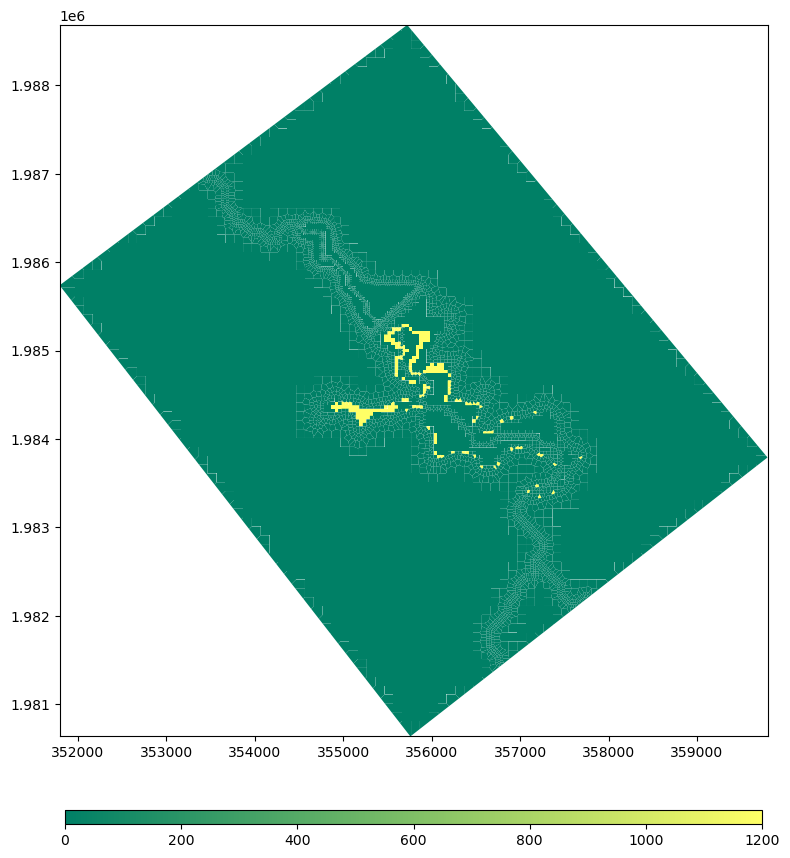

In [10]:
fig = plt.figure(figsize=(12, 12)) ## Org 
ax = fig.add_subplot(1, 1, 1, aspect = 'equal') ## Org 
mapview = flopy.plot.PlotMapView(model=gwf,layer = 2) ## Org 

plot_array = mapview.plot_array(strtConc,masked_values=[-1e+30], cmap=plt.cm.summer) ## Org 
plt.colorbar(plot_array, shrink=0.75,orientation='horizontal', pad=0.08, aspect=50) ## Org 

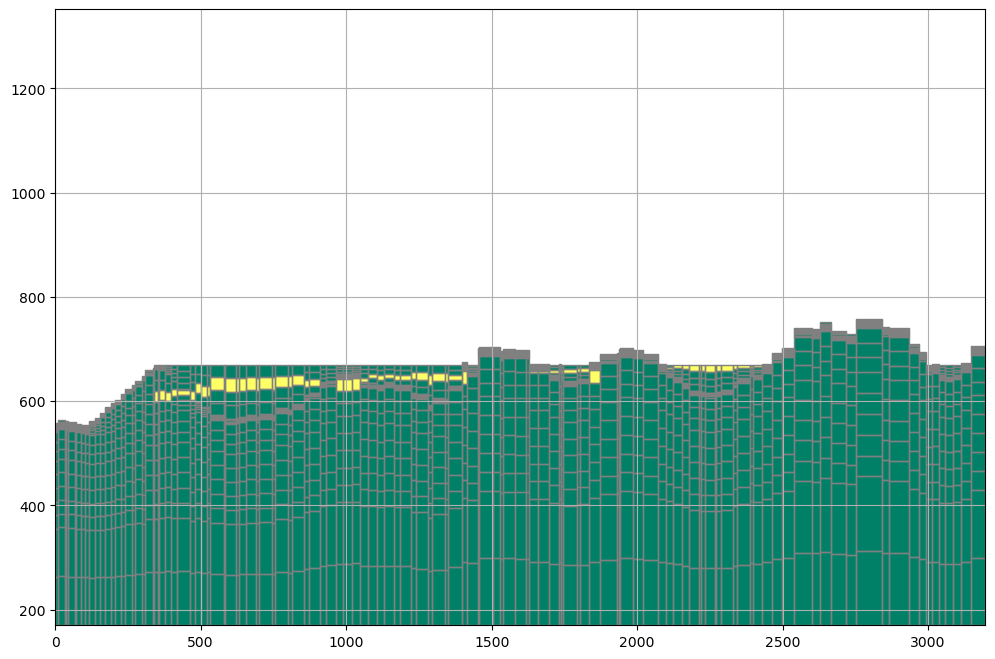

In [11]:
## <==== inserted
crossSection = gpd.read_file('../shp/tsf/crossSection.shp') ## <==== inserted
sectionLine =list(crossSection.iloc[0].geometry.coords) ## <==== inserted

fig, ax = plt.subplots(figsize=(12,8)) ## <==== inserted
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## <==== inserted
linecollection = modelxsect.plot_grid(lw=0.5) ## <==== inserted
modelxsect.plot_array(strtConc,masked_values=[-1e+30], cmap=plt.cm.summer) ## <====== inserted
modelxsect.plot_grid()
ax.grid() ## <==== inserted

In [12]:
# set advection, dispersion
adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM') ## Org 
dsp = flopy.mf6.ModflowGwtdsp(gwt, alh=1.0, ath1=0.1) ## Org 

#define mobile storage and transfer
porosity = 0.05 ## Org 
sto = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity) ## Org 

In [13]:
#define sink and source package
sourcerecarray = [()] ## Org 
ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray) ## Org 

The cell 6238 has a elevation of 670.11 outside the model vertical domain
The cell 6239 has a elevation of 670.12 outside the model vertical domain
The cell 6283 has a elevation of 671.17 outside the model vertical domain
The cell 6287 has a elevation of 671.34 outside the model vertical domain
The cell 6288 has a elevation of 670.70 outside the model vertical domain
The cell 6291 has a elevation of 670.35 outside the model vertical domain
The cell 6295 has a elevation of 670.93 outside the model vertical domain
The cell 6336 has a elevation of 670.67 outside the model vertical domain
The cell 6339 has a elevation of 670.23 outside the model vertical domain
The cell 6340 has a elevation of 670.43 outside the model vertical domain
The cell 6375 has a elevation of 670.20 outside the model vertical domain
The cell 6388 has a elevation of 670.17 outside the model vertical domain
The cell 6391 has a elevation of 670.06 outside the model vertical domain
The cell 6395 has a elevation of 670.0

[<Axes: title={'center': ' cnc_0 location stress period 1 layer 3'}>]

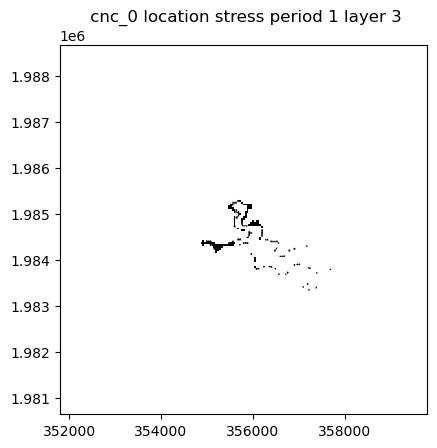

In [14]:
cncSpd = {} ## Org
cncSpd[0] = [] ## Org

layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf,
                                                               interIx,
                                                               '../output/waterTable.tif',
                                                               '../shp/tsf/tailingsEnvelope_v2.shp') 

for layCell in layCellTupleList:
    cncSpd[0].append([layCell[0],layCell[1],1200])

cnc = flopy.mf6.ModflowGwtcnc(gwt,stress_period_data=cncSpd) ## Org
cnc.plot(mflay=2) ## Org

In [15]:
obsList = []
nameList, obsLayCellList = getLayCellElevTupleFromObs(gwf, ## <===== modified
                  interIx, ## <===== modified
                  '../shp/tsf/piezometers.shp', ## <===== modified
                  'Name', ## <===== modified
                  'Elev') ## <===== modified

for obsName, obsLayCell in zip(nameList, obsLayCellList): ## Org
    obsList.append((obsName,'concentration',obsLayCell[0]+1,obsLayCell[1]+1)) ## Org


obs = flopy.mf6.ModflowUtlobs( ## Org
    gwt,
    filename=gwt.name+'.obs', ## Org
    digits=10, ## Org
    print_input=True, ## Org
    continuous={gwt.name+'.obs.csv': obsList} ## Org
)

Working for cell 1359
Well screen elev of 529.00 found at layer 9
Working for cell 1973
Well screen elev of 533.00 found at layer 9
Working for cell 2441
Well screen elev of 537.00 found at layer 9


In [16]:
#define output control
oc_gwt = flopy.mf6.ModflowGwtoc(gwt, ## Org
                                budget_filerecord='%s.cbc'%gwt.name, ## Org
                                concentration_filerecord='%s.ucn'%gwt.name, ## Org
                                saverecord=[('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')], ## Org
                                printrecord=[('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')], ## Org
                                )

In [17]:
pd = [ ## Org
    ("GWFHEAD", "../modelFiles/mf6Model.hds"), ##  <===== modified
    ("GWFBUDGET", "../modelFiles/mf6Model.cbc"), ##  <===== modified
]

fmi = flopy.mf6.ModflowGwtfmi(gwt, ## Org
                              flow_imbalance_correction=True, ## Org
                              packagedata=pd) ## Org

In [18]:
sim.write_simulation() ## Org
success, buff = sim.run_simulation() ## Org

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_0...
  writing model mf6model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
    writing package ghb_0...
    writing package oc...
  writing model gwtModel...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package cnc_0...
INFORMATION: maxbound in ('gwt6', 'cnc', 'dimensions') changed to 1624 based on size of stress_period_data
    writing package obs_0...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
   

In [19]:
concObj = gwt.output.concentration() ## Org
concObj.get_times() ## Org

[2522880000.0]

In [20]:
conc = concObj.get_data() ## Org
conc.shape ## Org

(19, 1, 7362)

In [21]:
transAoi = gpd.read_file('../shp/tsf/tailingsSeepage.shp') ## <==== updated
xMin, yMin, xMax, yMax = transAoi.bounds.iloc[0].values ## Org

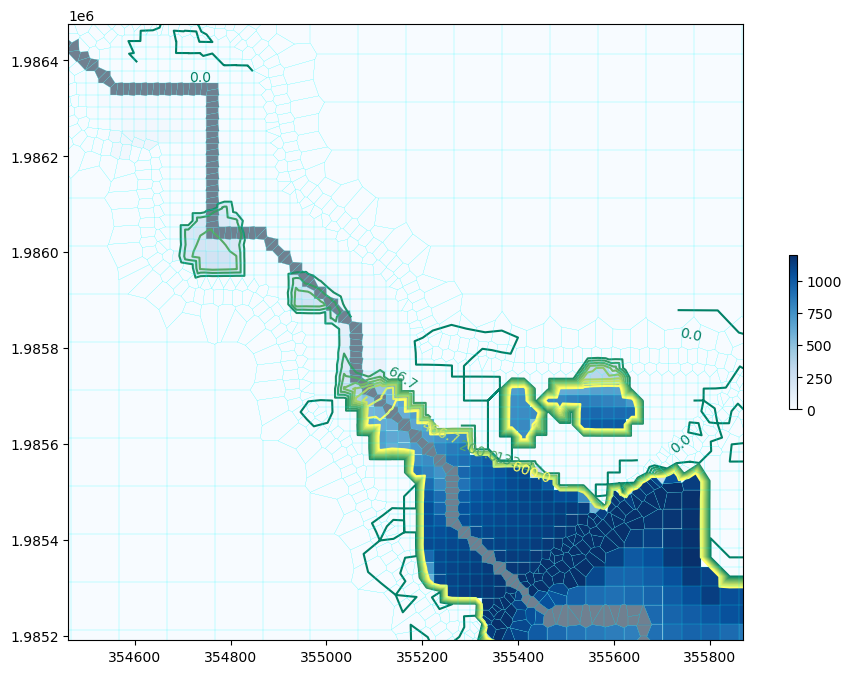

In [22]:
mflay = 7 ## Org

# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(12,8))  ## Org
ax = fig.add_subplot(1, 1, 1, aspect='equal')  ## Org
modelmap = flopy.plot.PlotMapView(model=gwf)  ## Org

levels = np.linspace(0,conc.max()/2,num=10)  ## Org
quadmesh = modelmap.plot_bc('DRN', color='crimson')  ## Org

contour = modelmap.contour_array(conc[mflay],ax=ax,levels=levels,cmap='summer')  ## Org
ax.clabel(contour)  ## Org

linecollection = modelmap.plot_grid(linewidth=0.1, alpha=0.8, color='cyan', ax=ax)  ## Org

cellConc = modelmap.plot_array(conc[mflay],ax=ax,cmap='Blues')  ## Org

quadmesh = modelmap.plot_bc('DRN', color='slategrey')  ## Org

#dump1 = modelmap.plot_shapefile('../shp/wasteDump1.shp')
#piezo = modelmap.plot_shapefile('../shp/piezometers2.shp', radius=10)

ax.set_xlim(xMin,xMax)
ax.set_ylim(yMin,yMax)

plt.colorbar(cellConc, shrink=0.25) 

plt.show() 

In [23]:
from mf6Voronoi.tools.graphs2d import generateRasterFromArray
generateRasterFromArray(gwf, 
                        conc[mflay][0],
                        meshLayer='../output/tailingsStorage.shp', 
                        rasterRes=10, 
                        epsg=32614,
                        outputPath='../output/conc_lay%d_80yrs.tif'%mflay)

Raster X Dim: 8005.97, Raster Y Dim: 8046.35
Number of cols:  801, Number of rows: 805
